<h1 align=center> 📹 End-to-End Video Emotion Recognition using MediaPipe and Pre-trained CNNs 🤖 </h1>

This project details a complete system for recognizing human emotions from short video clips, designed for a journaling application 📓 that uses video as a cover for entries.

A key innovation of this notebook is its unique approach to feature engineering. Instead of analyzing landmark data, this system processes videos by:
1.  Using **MediaPipe** 🌐 to detect and crop the face in each frame.
2.  Sampling these cropped face images at regular intervals throughout a video clip.
3.  Stacking the sequence of grayscale images into a single multi-channel tensor.

This tensor, which captures both spatial and temporal information, is then fed into a powerful, pre-trained **2D Convolutional Neural Network (CNN)** 🧠, such as EfficientNetV2 or MobileNetV3, for the final emotion classification. 😊

The resulting five emotion labels used for training are: 
- Anger
- Happy 
- Shock
- Neutral
- Sad

## 💡 Use Case Possibilities

While this model was initially designed for a journaling app, the core technology can be adapted for a wide range of powerful applications:

* **📓 Enhanced Digital Journaling & Mental Wellness:** The primary use case. The app can track mood patterns over time, helping users gain insight into their emotional wellbeing. It could suggest activities or resources based on detected emotional trends.

* **🧠 User Experience (UX) Research:** Companies can analyze user reactions to new software, websites, or products in real-time. This provides authentic, unbiased feedback on whether a feature is delightful, confusing, or frustrating.

* **📚 Adaptive E-Learning Platforms:** An online learning system could gauge a student's emotional state. If the system detects confusion or frustration, it could automatically offer hints, supplementary materials, or a different teaching approach.

* **🎬 Audience Reaction Analysis:** Media companies could use this to analyze audience reactions during movie screenings or trailer tests to gauge emotional engagement with the content.

* **🚗 Driver Monitoring Systems:** In-car cameras could use the model to detect driver states like drowsiness, distraction, or road rage, triggering safety alerts to prevent accidents.

<img src="./Assets/journaling_illustration.gif" alt="Journaling Illustration" width="720" height="405">

*The illustration is generated by AI

## ⚙️ 1. Project Setup and Data Acquisition

This project uses a custom video dataset collected by scraping from popular stock footage websites, including Pexels, Adobe Stock, Vecteezy, and Storyblocks. The collected videos are close-up shots of individuals displaying a range of emotions, ensuring a diverse and representative dataset for emotion recognition. 🎥😃

<img src="./Assets/data_collection_overview.png" alt="Data Collection and Structure Overview" width="900">

Each video is named according to its emotion class and a unique sequence number (e.g., `Anger_0001.mp4`). All videos are organized in a single folder named `Scrapping` inside the `Dataset` directory. The file structure is as follows: 📁

To replicate the dataset:  
1. 📥 Download or collect close-up face videos representing different emotions from stock footage providers.  
2. 🏷️ Name each file using the format `[EmotionClass]_[Sequence].mp4` (e.g., `Happy_0002.mp4`).  
3. 🗂️ Place all videos in a folder named `Scrapping` and compress it as a ZIP file.  
4. ☁️ Upload the ZIP file to Google Drive and set the file ID in your environment variables as `DATASET_DOWNLOAD_ID`.  

The notebook will automatically download and extract the dataset from Google Drive, preparing it for further processing and model training. ⚡🛠️

In [1]:
import os
os.environ["GLOG_minloglevel"] = "3"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import zipfile
import time
import csv
import gc
import random

import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import tifffile as tiff

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import gdown

from dotenv import load_dotenv
load_dotenv()



True

In [2]:
dataset_download_id = os.getenv('DATASET_DOWNLOAD_ID')
zip_path = os.path.join(os.getcwd(), 'Dataset', 'Scrapping.zip')
destination_path = os.path.join(os.getcwd(), 'Dataset', 'Scrapping')

# # Download from Google Drive
# os.makedirs(destination_path, exist_ok=True)
# gdown.download(id=dataset_download_id, output=zip_path, quiet=False)

# # Extract the downloaded ZIP file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_path)

# # Remove downloaded ZIP
# os.remove(zip_path)

In [3]:
# File Paths
VIDEO_SOURCE_DIR = os.path.join(os.getcwd(), 'Dataset', 'Scrapping')

for dir_path in [VIDEO_SOURCE_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    
# Feature Export Parameter
SEQUENCE_LENGTH = 90
MIN_SEQUENCE_LENGTH = 75
FACE_IMG_SIZE = (224, 224)
IMG_CAPTURE_INTERVAL = 15
VALIDATION_IDS = ['0016', '0017', '0018', '0019', '0020'] 

## 🛠️ 2. Data Preprocessing and Feature Extraction

Once the dataset is acquired, the next step is to preprocess the videos and extract features that are suitable for model training. 🧹🧑‍💻

<img src="./Assets/preprocessing_overview.png" width=900>

The preprocessing pipeline includes:

1. **Extracting Frames from Video:** 🖼️  
   Each video is split into individual frames.

2. **Face Landmark Detection:** 👁️  
   MediaPipe FaceMesh is used to detect facial landmarks on each frame.

3. **Preprocessing Frames:** ✂️🖤  
   - The frame is cropped to the face area.
   - The cropped face is converted to grayscale and resized to a standard size.

4. **Frame Sampling:** ⏱️🧮  
   Instead of using every frame, a sampling strategy is applied. For each 90-frame video segment, frames are sampled at a fixed interval. In this research, intervals of 5, 10, and 15 frames are tested.  
   - For example, with an interval of 5, you get 18 sampled frames per 90-frame sequence (90 / 5 = 18).
   - These sampled frames are then stacked along the channel dimension to form a multi-channel tensor.

5. **Padding:** 🧩  
   If the last sequence in a video has more than 75 frames but less than 90, the remaining frames are padded using the last available frame to ensure a consistent sequence length.

6. **Saving Features:** 💾  
   The stacked grayscale face images are saved as a multi-channel TIFF file, representing a single data point for model training.

This structured approach ensures that the model receives consistent and information-rich inputs for robust emotion recognition. 💡😊

<img src="./Assets/frame_sampling.png" width=1100>

In [ ]:
def get_face_bbox(frame_shape, landmarks, margin=0.1):
    """Calculate bounding box from landmarks with a margin."""
    h, w, _ = frame_shape
    x_coords = [lm.x * w for lm in landmarks]
    y_coords = [lm.y * h for lm in landmarks]
    
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    
    x_margin = (x_max - x_min) * margin
    y_margin = (y_max - y_min) * margin
    
    x_min = int(max(0, x_min - x_margin))
    x_max = int(min(w, x_max + x_margin))
    y_min = int(max(0, y_min - y_margin))
    y_max = int(min(h, y_max + y_margin))
    
    return x_min, y_min, x_max, y_max

In [ ]:
def write_video_chunk(output_path, frame_chunk, frame_size, fps):
    """
    Writes a list of frames to an MP4 video file.
    """
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
    for frame in frame_chunk:
        video_writer.write(frame)
    video_writer.release()

In [ ]:
def normalize_landmarks(landmarks_flat):
    """
    Normalizes facial landmarks for a single frame to be scale and position invariant.
    """
    
    landmarks = np.array(landmarks_flat).reshape(-1, 3)
    
    x_coords = landmarks[:, 0]
    y_coords = landmarks[:, 1]
    z_coords = landmarks[:, 2]
    
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    if x_max - x_min == 0 or y_max - y_min == 0:
        return landmarks_flat
        
    x_normalized = (x_coords - x_min) / (x_max - x_min)
    y_normalized = (y_coords - y_min) / (y_max - y_min)
    
    z_mean = np.mean(z_coords)
    z_normalized = z_coords - z_mean
    
    normalized_landmarks_flat = np.stack([x_normalized, y_normalized, z_normalized], axis=1).flatten().tolist()
    
    return normalized_landmarks_flat

In [ ]:
def setup_video_processing(video_path, label):
    """
    Initializes paths, directories, and video capture for processing.
    Determines if the video is for training or validation based on VALIDATION_IDS.
    """
    
    base_filename = os.path.splitext(os.path.basename(video_path))[0]
    
    # Determine if the file is for training or validation
    video_id = base_filename.split('_')[1]
    split_folder = 'val' if video_id in VALIDATION_IDS else 'train'

    # Define output directories with the new structure
    output_dirs = {
        'csv': os.path.join(os.getcwd(), 'Data', 'Scrapping', str(IMG_CAPTURE_INTERVAL), split_folder, 'FaceMesh', label),
        'tiff': os.path.join(os.getcwd(), 'Data', 'Scrapping', str(IMG_CAPTURE_INTERVAL), split_folder, 'FaceImage', label),
        'video': os.path.join(os.getcwd(), 'Data', 'Scrapping', str(IMG_CAPTURE_INTERVAL), split_folder, 'Video', label)
    }
    
    for d in output_dirs.values():
        os.makedirs(d, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    video_properties = {
        'fps': cap.get(cv2.CAP_PROP_FPS),
        'frame_size': (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    }
    
    return cap, base_filename, output_dirs, video_properties

In [ ]:
def process_frame_data(face_mesh, frame, last_known_landmarks):
    """
    Processes a single frame to extract facial landmarks.
    """
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)
    
    landmarks_present = False
    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]
        current_landmarks_flat = [c for lm in face_landmarks.landmark for c in (lm.x, lm.y, lm.z)]
        landmarks_present = True
    else:
        face_landmarks = None
        current_landmarks_flat = last_known_landmarks

    normalized_landmarks = normalize_landmarks(current_landmarks_flat)
    return normalized_landmarks, face_landmarks, current_landmarks_flat, landmarks_present

In [ ]:
def save_data_chunk(base_filename, chunk_idx, output_dirs, data_chunks, video_properties):
    """
    Saves the collected data chunks to files.
    """
    
    chunk_filename_base = f"{base_filename}_{chunk_idx:04d}"
    
    # Save CSV
    csv_path = os.path.join(output_dirs['csv'], f"{chunk_filename_base}.csv")
    header = ['frame'] + [f'p_{i}' for i in range(468 * 3)]
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(data_chunks['landmarks'])

    # Save TIFF
    if data_chunks['images']:
        tiff_path = os.path.join(output_dirs['tiff'], f"{chunk_filename_base}.tiff")
        images_array = np.array(data_chunks['images'])
        images_with_channel = np.expand_dims(images_array, axis=0) # Shape: (1, D, H, W)
        tiff.imwrite(tiff_path, images_with_channel, imagej=True)

    # Save Video
    video_path_out = os.path.join(output_dirs['video'], f"{chunk_filename_base}.mp4")
    write_video_chunk(video_path_out, data_chunks['frames'], video_properties['frame_size'], video_properties['fps'])

In [ ]:
def process_video(video_path, label):
    """
    Video feature extraction pipeline.
    """
    
    setup_info = setup_video_processing(video_path, label)
    if not setup_info:
        return
    cap, base_filename, output_dirs, video_properties = setup_info

    frame_idx, chunk_idx = 0, 1
    landmark_chunk, image_chunk, frame_chunk = [], [], []
    last_known_landmarks = [0] * (468 * 3)
    last_known_image = np.zeros(FACE_IMG_SIZE, dtype=np.uint8)

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_chunk.append(frame)
            
            normalized_landmarks, face_landmarks_obj, current_landmarks, landmarks_found = process_frame_data(face_mesh, frame, last_known_landmarks)
            last_known_landmarks = current_landmarks
            
            if frame_idx % IMG_CAPTURE_INTERVAL == 0:
                if landmarks_found:
                    x_min, y_min, x_max, y_max = get_face_bbox(frame.shape, face_landmarks_obj.landmark)
                    face_crop = frame[y_min:y_max, x_min:x_max]
                    if face_crop.size > 0:
                        gray_face = cv2.cvtColor(face_crop, cv2.COLOR_BGR2GRAY)
                        resized_face = cv2.resize(gray_face, FACE_IMG_SIZE, interpolation=cv2.INTER_AREA)
                        last_known_image = resized_face # Update the last known image
                        image_chunk.append(last_known_image)
                    else:
                        # If crop is empty, use the last known good image
                        image_chunk.append(last_known_image)
                else:
                    # If no landmarks are found, use the last known good image
                    image_chunk.append(last_known_image)

            landmark_chunk.append([frame_idx] + normalized_landmarks)
            frame_idx += 1

            if len(landmark_chunk) == SEQUENCE_LENGTH:
                data_chunks = {'landmarks': landmark_chunk, 'images': image_chunk, 'frames': frame_chunk}
                save_data_chunk(base_filename, chunk_idx, output_dirs, data_chunks, video_properties)
                
                chunk_idx += 1
                landmark_chunk, image_chunk, frame_chunk = [], [], []
                # Reset last_known_image for the new chunk to avoid carry-over
                last_known_image = np.zeros(FACE_IMG_SIZE, dtype=np.uint8)

    if len(landmark_chunk) >= MIN_SEQUENCE_LENGTH:
        last_landmark_row = landmark_chunk[-1]
        last_frame = frame_chunk[-1]
        
        # Pad the image chunk to its expected size using the last known image
        num_images_expected = -(-SEQUENCE_LENGTH // IMG_CAPTURE_INTERVAL) # Ceiling division
        while len(image_chunk) < num_images_expected:
            image_chunk.append(last_known_image)

        # Pad the landmark and frame chunks to the full sequence length
        while len(landmark_chunk) < SEQUENCE_LENGTH:
            landmark_chunk.append(last_landmark_row)
            frame_chunk.append(last_frame)
        
        data_chunks = {'landmarks': landmark_chunk, 'images': image_chunk, 'frames': frame_chunk}
        save_data_chunk(base_filename, chunk_idx, output_dirs, data_chunks, video_properties)

    cap.release()

In [ ]:
def worker_task(args):
    filename, label = args
    video_path = os.path.join(VIDEO_SOURCE_DIR, filename)
    try:
        process_video(video_path, label)
    except Exception as e:
        print(f"Failed to process {video_path}. Error: {e}")

all_tasks = []
for filename in os.listdir(VIDEO_SOURCE_DIR):
    if filename.endswith('.mp4'):
        try:
            label = filename.split('_')[0] 
            all_tasks.append((filename, label))
        except IndexError:
            print(f"Skipping file with unexpected format: {filename}")


with ThreadPoolExecutor(max_workers=os.cpu_count() // 2) as executor:
    list(tqdm(executor.map(worker_task, all_tasks), total=len(all_tasks), desc="Processing Videos"))

## 🧠 3. Model Training and Evaluation

After preprocessing and feature extraction, the stacked grayscale face images (saved as multi-channel TIFF files) are used to train deep learning models for emotion classification. 🏋️‍♂️

### 🏗️ Model Architecture

This project leverages state-of-the-art pre-trained 2D Convolutional Neural Networks (CNNs) as feature extractors, adapted to handle multi-channel temporal image stacks:

- **EfficientNetV2-S** ⚡
- **EfficientNetV2-M** 🚀
- **MobileNetV3-Large** 📱

Each model's first convolutional layer is modified to accept the number of channels corresponding to the number of sampled frames (e.g., 18 channels for a 90-frame sequence with interval 5). The final classification layers are replaced to match the number of emotion classes.

#### 📊 Model & Sampling Interval Table

The table below summarizes the different model architectures and the sampling intervals tested in this research. Each cell will later be filled with the corresponding model's performance or parameter size. 📏

| EfficientNetV2-S ⚡ | EfficientNetV2-M 🚀 | MobileNetV3-Large 📱 |
|--------------------|---------------------|----------------------|
|20,839,165          |53,520,033           |3,468,709             |

#### ⚙️ Training Parameters

The following table lists the main training parameters used for all experiments:

| 🏷️ Parameter         | 🧩 Value                    |
|----------------------|----------------------------|
| Loss Function        | Cross-Entropy Loss          |
| Optimizer            | Adam                        |
| Learning Rate        | 1e-4                        |
| Weight Decay         | 1e-5                        |
| LR Scheduler         | Exponential (gamma=0.985)   |
| Batch Size           | 24                          |
| Epochs               | 50                          |
| Augmentation         | Flip, Affine, Blur, Erasing |
| Validation Split     | Predefined video IDs        |

### 🏃‍♂️ Training Procedure

- **Loss Function:** Cross-entropy loss is used for multi-class emotion classification. 🎯
- **Optimizer:** Adam optimizer with weight decay for regularization. 🧮
- **Learning Rate Scheduler:** Exponential decay scheduler to gradually reduce the learning rate. 📉
- **Augmentation:** Data augmentation (random flip, affine, blur, erasing) is applied during training to improve generalization. 🌀
- **Validation:** A portion of the data is reserved for validation to monitor overfitting and select the best model. 🧐

### 📝 Evaluation

After training, the best model (based on validation accuracy) is evaluated on the validation set. Performance metrics include:

- **Accuracy** 🎯
- **Classification Report:** Precision, recall, and F1-score for each emotion class. 📋
- **Confusion Matrix:** Visualizes the model's predictions versus true labels. 🟦

This approach ensures robust and generalizable emotion recognition from video sequences. 🤗

In [4]:
DATA_DIR = os.path.join(os.getcwd(), 'Data', 'Scrapping')
BATCH_SIZE = 24

TRAIN_DIR = os.path.join(DATA_DIR, str(IMG_CAPTURE_INTERVAL), 'train')
VAL_DIR = os.path.join(DATA_DIR, str(IMG_CAPTURE_INTERVAL), 'val')

for dir_path in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(dir_path, exist_ok=True)

In [5]:
class ImageDataset(Dataset):
    """
    A dataset that loads only the TIFF image sequences and their corresponding labels.
    """
    def __init__(self, image_file_paths, labels, label_map, is_train=False):
        super().__init__()
        self.image_file_paths = image_file_paths
        self.str_labels = labels
        self.label_map = label_map
        self.is_train = is_train

        # Define the image augmentation pipeline, only used if is_train is True
        if self.is_train:
            self.image_augment = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.75, 1.05)),
                T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
                T.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0),
            ])

        self.image_tensors = []
        self.label_tensors = []

        def _load_file(args):
            image_path, label_str = args
            try:
                # Load image data (TIFF), normalize to [0, 1], and squeeze the first dimension
                image_data = torch.tensor(tiff.imread(image_path), dtype=torch.float32).squeeze(0) / 255.0

                # Apply augmentation only to the training set
                if self.is_train:
                    image_data = self.image_augment(image_data)

                # Get label
                label_int = self.label_map[label_str]
                label = torch.tensor(label_int, dtype=torch.long)
                
                return image_data, label
            except Exception as e:
                print(f"Skipping file due to error: {image_path} | Error: {e}")
                return None, None

        # Parallelized Data Loading
        tasks = zip(self.image_file_paths, self.str_labels)
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            results = list(tqdm(executor.map(_load_file, tasks), total=len(self.image_file_paths), desc="Processing image files"))

        for img_data, lbl in results:
            if all(x is not None for x in [img_data, lbl]):
                self.image_tensors.append(img_data)
                self.label_tensors.append(lbl)

    def __len__(self):
        return len(self.label_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx], self.label_tensors[idx]

In [6]:
def get_image_files_and_labels(split_dir):
    files = []
    labels = []
    faceimage_dir = os.path.join(split_dir, 'FaceImage')
    if not os.path.isdir(faceimage_dir):
        return [], []
    
    emotion_folders = [d for d in os.listdir(faceimage_dir) if os.path.isdir(os.path.join(faceimage_dir, d))]
    for emotion in emotion_folders:
        emotion_path = os.path.join(faceimage_dir, emotion)
        tiff_files = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path) if f.endswith('.tiff')]
        files.extend(tiff_files)
        labels.extend([emotion] * len(tiff_files))
    return files, labels

train_image_files, train_image_labels_str = get_image_files_and_labels(TRAIN_DIR)
val_image_files, val_image_labels_str = get_image_files_and_labels(VAL_DIR)

emotion_folders = [d for d in os.listdir(os.path.join(TRAIN_DIR, 'FaceImage')) if os.path.isdir(os.path.join(TRAIN_DIR, 'FaceImage', d))]
unique_labels = sorted(emotion_folders)
label_map = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(label_map)

train_image_dataset = ImageDataset(train_image_files, train_image_labels_str, label_map, is_train=True)
val_image_dataset = ImageDataset(val_image_files, val_image_labels_str, label_map, is_train=False)

train_image_loader = DataLoader(train_image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_image_loader = DataLoader(val_image_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Processing image files: 100%|██████████| 92/92 [00:00<00:00, 1629.96it/s]


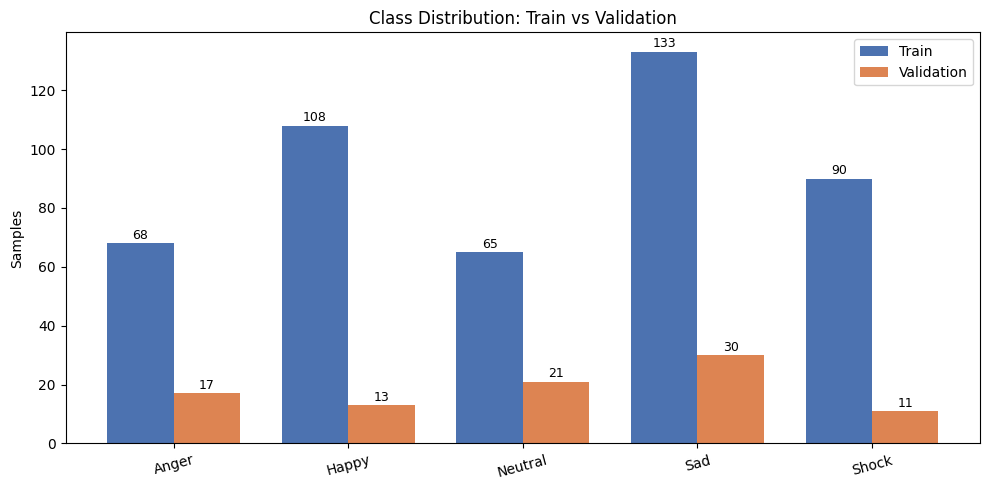

Class   | Train (n) | Train (%) | Val (n) | Val (%)
--------------------------------------------------
Anger            68     14.66%        17    18.48%
Happy           108     23.28%        13    14.13%
Neutral          65     14.01%        21    22.83%
Sad             133     28.66%        30    32.61%
Shock            90     19.40%        11    11.96%

Total Train: 464 | Total Val: 92


In [7]:
# 🔢 Class Distribution: Train vs Validation
from collections import Counter

# Count occurrences per class (string labels stored in dataset)
train_counts = Counter(train_image_dataset.str_labels)
val_counts   = Counter(val_image_dataset.str_labels)

classes = sorted(label_map.keys())
train_values = [train_counts.get(c, 0) for c in classes]
val_values   = [val_counts.get(c, 0) for c in classes]

# Totals and percentages
train_total = sum(train_values)
val_total = sum(val_values)
train_pct = [v / train_total * 100 if train_total else 0 for v in train_values]
val_pct   = [v / val_total * 100 if val_total else 0 for v in val_values]

# Bar plot side-by-side
x = np.arange(len(classes))
width = 0.38

plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - width/2, train_values, width, label='Train', color='#4C72B0')
bars2 = plt.bar(x + width/2, val_values, width, label='Validation', color='#DD8452')

# Annotate counts
for b in bars1:
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5, str(int(b.get_height())),
             ha='center', va='bottom', fontsize=9)
for b in bars2:
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5, str(int(b.get_height())),
             ha='center', va='bottom', fontsize=9)

plt.xticks(x, classes, rotation=15)
plt.ylabel('Samples')
plt.title('Class Distribution: Train vs Validation')
plt.legend()
plt.tight_layout()
plt.show()

# Percentage table printout
print("Class   | Train (n) | Train (%) | Val (n) | Val (%)")
print("-"*50)
for c, tv, vv, tp, vp in zip(classes, train_values, val_values, train_pct, val_pct):
    print(f"{c:<8} {tv:>10} {tp:>9.2f}% {vv:>9} {vp:>8.2f}%")

print(f"\nTotal Train: {train_total} | Total Val: {val_total}")

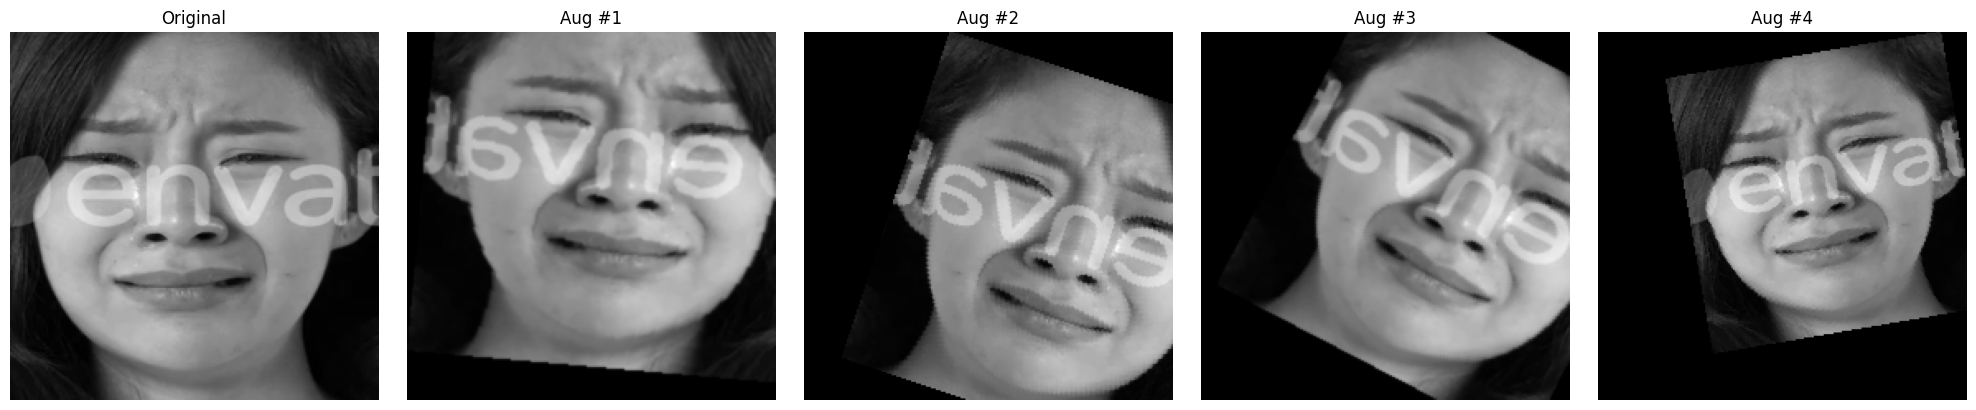

In [8]:
# Same augmentation as the training set
augment_pipeline = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.75, 1.05)),
    T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
    T.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0),
])

sample_path = random.choice(train_image_files) if len(train_image_files) else None

orig_stack = torch.tensor(tiff.imread(sample_path), dtype=torch.float32).squeeze(0) / 255.0  # (D,H,W)
orig_first = orig_stack[0].cpu().numpy()

aug_first_images = []
for i in range(4):
    aug_stack = augment_pipeline(orig_stack.clone())
    aug_first_images.append(aug_stack[0].cpu().numpy())

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes[0].imshow(orig_first, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

for i, img in enumerate(aug_first_images, start=1):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Aug #{i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### EfficientNetV2M

A medium-capacity backbone balancing accuracy and speed, EfficientNetV2-M scales depth, width, and resolution with improved training efficiency. Its architecture uses early FusedMBConv blocks (fast, no SE) for shallow stages and transitions to MBConv with Squeeze-and-Excitation for richer representation learning 🧠. In this project it is adapted by:

Replacing the stem conv to accept multi-channel grayscale temporal stacks (frames as channels) 🗂️
Retaining full feature extractor while swapping the original classifier for a custom head: Dropout(0.6) → Linear(→512) → ReLU → Dropout(0.5) → Linear(→num_classes) 🎯
Stronger depth (e.g., large MBConv stacks at stages 5–7) makes it suitable when more data or regularization is available
Use when aiming for higher accuracy with tolerable compute cost ⚖️.

**Model Layers**

| Stage | Layer/Block Type | Blocks | Kernel | Expansion (t) | Output Ch | Stride (first) | SE | Activation | Notes |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :--- |
| 0 | Stem Conv | 1 | 3x3 | - | 24 | 2 | No | SiLU | in_channels = num_input_channels (modified) |
| 1 | FusedMBConv | 3 | 3x3 | 1 | 24 | 1 | No | SiLU | All stride=1 |
| 2 | FusedMBConv | 5 | 3x3 | 4 | 48 | 2 | No | SiLU | Downsample first |
| 3 | FusedMBConv | 5 | 5x5 | 4 | 80 | 2 | No | SiLU | Larger kernel |
| 4 | MBConv | 7 | 3x3 | 6 | 160 | 2 | Yes | SiLU | SE starts |
| 5 | MBConv | 14 | 3x3 | 6 | 176 | 1 | Yes | SiLU | High repetition |
| 6 | MBConv | 18 | 3x3 | 6 | 304 | 2 | Yes | SiLU | Channel jump |
| 7 | MBConv | 5 | 3x3 | 6 | 512 | 1 | Yes | SiLU | Final stack |
| 8 | Head Conv 1x1 | 1 | 1x1 | - | 1280 | 1 | No | SiLU | Feature squeeze |
| 9 | Global Avg Pool | 1 | - | - | 1280 | - | - | - | Adaptive (1x1) |
| 10 | Dropout | 1 | - | - | 1280 | - | - | - | p=0.6 |
| 11 | Linear | 1 | - | - | 1280→512 | - | - | - | Classifier start |
| 12 | ReLU | 1 | - | - | 512 | - | - | ReLU | inplace=False |
| 13 | Dropout | 1 | - | - | 512 | - | - | - | p=0.5 |
| 14 | Linear (Logits) | 1 | - | - | 512→num_classes | - | - | - | Output layer |

In [9]:
class EfficientNetV2ModelM(nn.Module):
    def __init__(self, num_classes, num_input_channels):
        super(EfficientNetV2ModelM, self).__init__()

        self.efficientnet = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)

        original_first_layer = self.efficientnet.features[0][0]
        # Create a new conv layer with the correct number of input channels
        first_layer = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=original_first_layer.out_channels,
            kernel_size=original_first_layer.kernel_size,
            stride=original_first_layer.stride,
            padding=original_first_layer.padding,
            bias=original_first_layer.bias
        )
        
        with torch.no_grad():
            first_layer.weight.data = original_first_layer.weight.data.mean(dim=1, keepdim=True).repeat(1, num_input_channels, 1, 1)

        self.efficientnet.features[0][0] = first_layer

        in_features = self.efficientnet.classifier[1].in_features
        hidden_dim = 512
        
        # Dense layers after EfficientNet
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.6, inplace=False),
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

### EfficientNetV2S

A lighter variant optimized for faster convergence and lower latency, EfficientNetV2-S reduces block counts versus M while keeping the same design principles (early fused blocks, later SE-enabled MBConv). Its shallower mid/late stages make it less prone to overfitting on smaller datasets 📉. Customizations here mirror M: temporal multi-channel input adaptation, weight initialization by channel replication, and a compact dense head with aggressive dropout for regularization 💡.
Choose this when GPU memory is limited, you need quicker experimentation, or diminishing returns appear with the M model ⏱️.

**Model Layers**

| Stage | Layer/Block Type | Blocks | Kernel | Expansion (t) | Output Ch | Stride (first) | SE | Activation | Notes |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :--- |
| 0 | Stem Conv | 1 | 3x3 | - | 24 | 2 | No | SiLU | in_channels = num_input_channels (modified) |
| 1 | FusedMBConv | 2 | 3x3 | 1 | 24 | 1 | No | SiLU | All stride=1 |
| 2 | FusedMBConv | 4 | 3x3 | 4 | 48 | 2 (then 1) | No | SiLU | First block downsamples |
| 3 | FusedMBConv | 4 | 3x3 | 4 | 64 | 2 (then 1) | No | SiLU | Channel + spatial downsample |
| 4 | MBConv | 6 | 3x3 | 4 | 128 | 2 (then 1) | Yes | SiLU | SE introduced |
| 5 | MBConv | 9 | 3x3 | 6 | 160 | 1 | Yes | SiLU | High repetition |
| 6 | MBConv | 15 | 3x3 | 6 | 256 | 2 (then 1) | Yes | SiLU | Largest stack |
| 7 | Head Conv 1x1 | 1 | 1x1 | - | 1280 | 1 | No | SiLU | Feature aggregation |
| 8 | Global Avg Pool | 1 | - | - | 1280 | - | - | - | Adaptive (1x1) |
| 9 | Dropout | 1 | - | - | 1280 | - | - | - | p=0.6 |
| 10 | Linear | 1 | - | - | 1280→512 | - | - | - | Custom classifier start |
| 11 | ReLU | 1 | - | - | 512 | - | - | ReLU | inplace=False |
| 12 | Dropout | 1 | - | - | 512 | - | - | - | p=0.5 |
| 13 | Linear (Logits) | 1 | - | - | 512→num_classes | - | - | - | Output layer |

In [10]:
class EfficientNetV2ModelS(nn.Module):
    def __init__(self, num_classes, num_input_channels):
        super(EfficientNetV2ModelS, self).__init__()

        self.efficientnet = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

        original_first_layer = self.efficientnet.features[0][0]
        # Create a new conv layer with the correct number of input channels
        first_layer = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=original_first_layer.out_channels,
            kernel_size=original_first_layer.kernel_size,
            stride=original_first_layer.stride,
            padding=original_first_layer.padding,
            bias=original_first_layer.bias
        )
        
        with torch.no_grad():
            first_layer.weight.data = original_first_layer.weight.data.mean(dim=1, keepdim=True).repeat(1, num_input_channels, 1, 1)
            
        self.efficientnet.features[0][0] = first_layer
        
        in_features = self.efficientnet.classifier[1].in_features
        hidden_dim = 512
        
        # Dense layers after EfficientNet
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.6, inplace=False),
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

### MobileNetV3Large

Designed for mobile/edge deployment, MobileNetV3-Large blends lightweight inverted residual (BNeck) blocks with Squeeze-and-Excitation and h-swish activation for efficiency ⚙️. Larger expansions in mid–late stages (e.g., 672→960) offer feature richness while keeping FLOPs low. Project adaptations include:

Modified stem conv to accept stacked grayscale frames as channels 🧩
Classifier replaced: Dropout(0.6) → Linear(→512) → ReLU → Dropout(0.5) → Linear(→num_classes)
Channel replication initialization preserves pretrained spatial filters despite temporal stacking 🪄
Best when targeting deployment or fast iteration with minimal resource footprint 🔋.

**Model Layers**

| Stage | Layer/Block Type | Blocks | Kernel | Expansion (t) | Output Ch | Stride (first) | SE | Activation | Notes |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :--- |
| 0 | Stem Conv | 1 | 3x3 | - | 16 | 2 | No | h-swish | in_channels = num_input_channels (modified) |
| 1 | BNeck | 1 | 3x3 | 16 | 16 | 1 | No | ReLU | - |
| 2 | BNeck | 2 | 3x3 | 64, 72 | 24 | 2 | No | ReLU | First downsamples |
| 3 | BNeck | 3 | 5x5 | 72, 120, 120 | 40 | 2 | Yes | ReLU | SE introduced |
| 4 | BNeck | 4 | 3x3 | 240, 200, 184, 184 | 80 | 2 | No | h-swish | Mixed expansions |
| 5 | BNeck | 2 | 3x3 | 480, 672 | 112 | 1 | Yes | h-swish | All stride=1 |
| 6 | BNeck | 3 | 5x5 | 672, 960, 960 | 160 | 2 | Yes | h-swish | Final downsample |
| 7 | Conv 1x1 | 1 | 1x1 | - | 960 | 1 | No | h-swish | Feature projection |
| 8 | Global Avg Pool | 1 | - | - | 960 | - | - | - | Adaptive (1x1) |
| 9 | Dropout | 1 | - | - | 960 | - | - | - | p=0.6 |
| 10 | Linear | 1 | - | - | 960→512 | - | - | - | Custom classifier start |
| 11 | ReLU | 1 | - | - | 512 | - | - | ReLU | inplace=False |
| 12 | Dropout | 1 | - | - | 512 | - | - | - | p=0.5 |
| 13 | Linear (Logits) | 1 | - | - | 512→num_classes | - | - | - | Output layer |

In [11]:
class MobileNetV3Large(nn.Module):
    def __init__(self, num_classes, num_input_channels):
        super(MobileNetV3Large, self).__init__()

        self.mobilenet = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

        original_first_layer = self.mobilenet.features[0][0]
        first_layer = nn.Conv2d(
            in_channels=num_input_channels,
            out_channels=original_first_layer.out_channels,
            kernel_size=original_first_layer.kernel_size,
            stride=original_first_layer.stride,
            padding=original_first_layer.padding,
            bias=original_first_layer.bias
        )
        with torch.no_grad():
            first_layer.weight.data = original_first_layer.weight.data.mean(dim=1, keepdim=True).repeat(1, num_input_channels, 1, 1)
        self.mobilenet.features[0][0] = first_layer

        in_features = self.mobilenet.classifier[0].in_features
        hidden_dim = 512
        
        # Dense layers after MobileNet
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(p=0.6, inplace=False),
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.mobilenet(x)


### Model Training
**Learning Rate (1e-4) 🧪**  
Small enough to protect pretrained features, large enough to reach good accuracy in ~50 epochs without warmup.

**Exponential Decay (gamma = 0.985) 📉**  
LR_new = LR_prev * 0.985 current epoch → 

This leads to 50% smaller LR after 50 epochs. Smooth, single-parameter, no milestone tuning, stabilizes late training.


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    device,
    save_dir,
    log_file_name,
    learning_rate=1e-4,
    weight_decay=1e-5,
    gamma=0.985
):
    
    os.makedirs(save_dir, exist_ok=True)
    log_file_path = os.path.join(save_dir, log_file_name)
    log_header = ['epoch', 'time_seconds', 'train_acc', 'train_loss', 'val_acc', 'val_loss', 'learning_rate']

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_val_loss = float('inf')

    with open(log_file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(log_header)

    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for image_batch, labels_batch in train_pbar:
            image_batch, labels_batch = image_batch.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(image_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels_batch.size(0)
            train_correct += (predicted == labels_batch).sum().item()
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(predicted == labels_batch).sum().item() / labels_batch.size(0):.4f}'})

        train_acc = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for image_batch, labels_batch in val_pbar:
                image_batch, labels_batch = image_batch.to(device), labels_batch.to(device)
                outputs = model(image_batch)
                loss = criterion(outputs, labels_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(predicted == labels_batch).sum().item() / labels_batch.size(0):.4f}'})

        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        # Logging and Model Saving
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_duration:.2f}s | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.6f}")

        with open(log_file_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, epoch_duration, train_acc, avg_train_loss, val_acc, avg_val_loss, current_lr])

        torch.save(model.state_dict(), os.path.join(save_dir, 'last_model.pth'))

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_val_acc_model.pth'))
            print(f"🎉 New best val acc model saved: {val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_val_loss_model.pth'))
            print(f"✨ New best val loss model saved: {avg_val_loss:.4f}")

    total_training_time = time.time() - start_time
    print(f"\n--- Training Finished ---")
    print(f"Total Training Time: {total_training_time / 60:.2f} minutes")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Lowest Validation Loss: {best_val_loss:.4f}")
    
    del model
    del optimizer
    torch.cuda.empty_cache()
    gc.collect()

In [14]:
image_channels = -(-SEQUENCE_LENGTH // IMG_CAPTURE_INTERVAL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
efficientnetv2s_model = EfficientNetV2ModelS(
    num_classes=num_classes,
    num_input_channels=image_channels
).to(device)

print("EfficientNetV2-S Summary:")
print(summary(efficientnetv2s_model, input_size=(BATCH_SIZE, image_channels, FACE_IMG_SIZE[0], FACE_IMG_SIZE[1])), '\n\n')

train_model(
    efficientnetv2s_model,
    train_image_loader,
    val_image_loader,
    num_epochs=50,
    device=device,
    save_dir=os.path.join(os.getcwd(), "Models", f"Models_EfficientNetV2S_{IMG_CAPTURE_INTERVAL}"),
    log_file_name="training_logs_efficientnetv2s.csv"
)

In [ ]:
efficientnetv2m_model = EfficientNetV2ModelM(
    num_classes=num_classes,
    num_input_channels=image_channels
).to(device)

print("EfficientNetV2-M Summary:")
print(summary(efficientnetv2m_model, input_size=(BATCH_SIZE, image_channels, FACE_IMG_SIZE[0], FACE_IMG_SIZE[1])), '\n\n')

train_model(
    efficientnetv2m_model,
    train_image_loader,
    val_image_loader,
    num_epochs=50,
    device=device,
    save_dir=os.path.join(os.getcwd(), "Models", f"Models_EfficientNetV2M_{IMG_CAPTURE_INTERVAL}"),
    log_file_name="training_logs_efficientnetv2m.csv"
)

In [ ]:
mobilenetv3large_model = MobileNetV3Large(
    num_classes=num_classes,
    num_input_channels=image_channels
).to(device)

print("MobileNetV3Large Summary:")
print(summary(mobilenetv3large_model, input_size=(BATCH_SIZE, image_channels, FACE_IMG_SIZE[0], FACE_IMG_SIZE[1])), '\n\n')

train_model(
    mobilenetv3large_model,
    train_image_loader,
    val_image_loader,
    num_epochs=50,
    device=device,
    save_dir=os.path.join(os.getcwd(), "Models", f"Models_MobileNetV3Large_{IMG_CAPTURE_INTERVAL}"),
    log_file_name="training_logs_mobilenetv3large.csv"
)

### Model Evaluation

- **Accuracy 🎯**  
  Measures the overall percentage of correct predictions.  
  In emotion classification, it tells you how often the model predicts the correct emotion label (e.g., "Happy", "Sad") for a video sample.

- **Precision 🧐**  
  For each emotion, precision is the proportion of samples predicted as that emotion that are actually correct.  
  Example: If the model predicts "Anger" 10 times and 8 are truly "Anger", precision for "Anger" is 80%.  
  High precision means fewer false positives (the model doesn't wrongly label other emotions as "Anger").

- **Recall 🔍**  
  For each emotion, recall is the proportion of actual samples of that emotion that the model correctly identifies.  
  Example: If there are 12 true "Happy" videos and the model finds 9, recall for "Happy" is 75%.  
  High recall means the model misses fewer true cases (few false negatives).

**In summary:**  
- Accuracy gives a big-picture view of correctness.  
- Precision shows how reliable each emotion prediction is.  
- Recall shows how well the model finds all examples of each emotion.  

In [15]:
def evaluate_model(
    model_class, 
    model_kwargs, 
    best_model_path, 
    val_loader, 
    device, 
    label_map
):
    # Instantiate and load weights
    model = model_class(**model_kwargs).to(device)
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Reverse label_map for readable output
    idx_to_label = {v: k for k, v in label_map.items()}
    target_names = [idx_to_label[i] for i in range(len(idx_to_label))]

    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc * 100:.2f}%")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

=== EfficientNetV2S ===
Accuracy: 79.35%
Classification Report:
              precision    recall  f1-score   support

       Anger       0.69      0.53      0.60        17
       Happy       0.91      0.77      0.83        13
     Neutral       0.77      0.95      0.85        21
         Sad       0.79      0.90      0.84        30
       Shock       0.88      0.64      0.74        11

    accuracy                           0.79        92
   macro avg       0.81      0.76      0.77        92
weighted avg       0.80      0.79      0.79        92



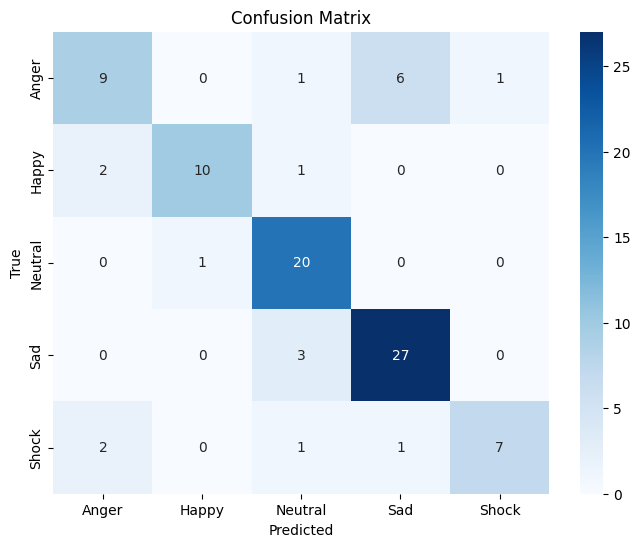

In [16]:
print("=== EfficientNetV2S ===")
evaluate_model(
    EfficientNetV2ModelS,
    {"num_classes": num_classes, "num_input_channels": image_channels},
    os.path.join(os.getcwd(), "Models", f"Models_EfficientNetV2S_{IMG_CAPTURE_INTERVAL}", "best_val_acc_model.pth"),
    val_image_loader,
    device,
    label_map
)

=== EfficientNetV2M ===
Accuracy: 73.91%
Classification Report:
              precision    recall  f1-score   support

       Anger       0.80      0.24      0.36        17
       Happy       0.82      0.69      0.75        13
     Neutral       0.90      0.86      0.88        21
         Sad       0.60      0.93      0.73        30
       Shock       1.00      0.82      0.90        11

    accuracy                           0.74        92
   macro avg       0.82      0.71      0.72        92
weighted avg       0.78      0.74      0.72        92



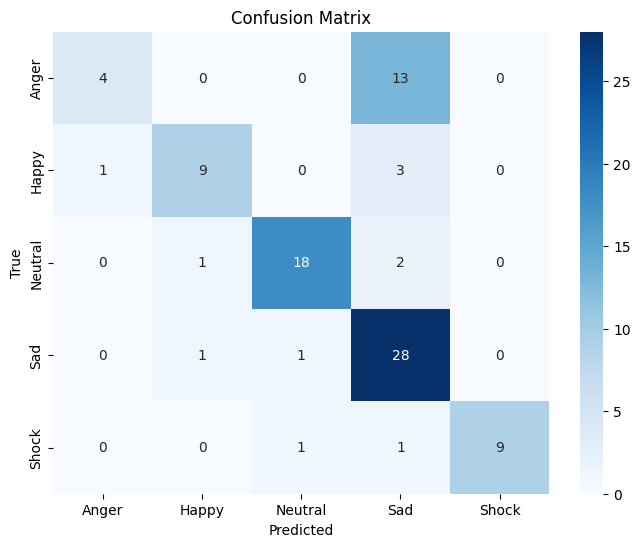

In [17]:
print("=== EfficientNetV2M ===")
evaluate_model(
    EfficientNetV2ModelM,
    {"num_classes": num_classes, "num_input_channels": image_channels},
    os.path.join(os.getcwd(), "Models", f"Models_EfficientNetV2M_{IMG_CAPTURE_INTERVAL}", "best_val_acc_model.pth"),
    val_image_loader,
    device,
    label_map
)

=== MobileNetV3Large ===
Accuracy: 77.17%
Classification Report:
              precision    recall  f1-score   support

       Anger       0.71      0.71      0.71        17
       Happy       0.75      0.46      0.57        13
     Neutral       0.71      0.95      0.82        21
         Sad       0.90      0.90      0.90        30
       Shock       0.67      0.55      0.60        11

    accuracy                           0.77        92
   macro avg       0.75      0.71      0.72        92
weighted avg       0.77      0.77      0.76        92



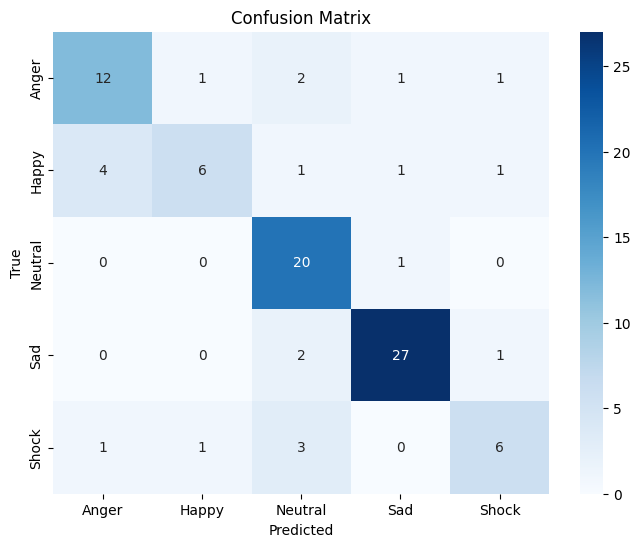

In [18]:
print("=== MobileNetV3Large ===")
evaluate_model(
    MobileNetV3Large,
    {"num_classes": num_classes, "num_input_channels": image_channels},
    os.path.join(os.getcwd(), "Models", f"Models_MobileNetV3Large_{IMG_CAPTURE_INTERVAL}", "best_val_acc_model.pth"),
    val_image_loader,
    device,
    label_map
)

### 📊 Model Performance and Confusion Matrix Analysis

The table below summarizes the validation accuracy of each model (MobileNetV3-Large, EfficientNetV2-S, EfficientNetV2-M) across different image sampling intervals and channel lengths. The number of parameters for each model is shown below the model name.

| Image Interval | Channel Length | <div align="center">MobileNetV3Large<br>3.469 M params</div> | <div align="center">EfficientNetV2S<br>20.839 M params</div> | <div align="center">EfficientNetV2M<br>53.520 M params</div> |
|:--------------:|:--------------:|:----------------------------------------------------------:|:----------------------------------------------------------:|:----------------------------------------------------------:|
|       5        |       18       |64.13%                                                      |**85.87%**                                                  |82.61%                                                      |
|      10        |        9       |61.69%                                                      |**76.09%**                                                  |73.91%                                                      |
|      15        |        5       |77.17%                                                      |**79.35%**                                                  |73.91%                                                      |

#### 📝 **Result Summary**

- **EfficientNetV2-S** achieves the highest accuracy across all intervals, especially at interval 5 (85.87%), showing strong generalization and robustness.
- **EfficientNetV2-M** also performs well, slightly below EfficientNetV2-S, indicating that larger models do not always guarantee better results for this dataset.
- **MobileNetV3-Large** has the lowest parameter count and is fastest, but its accuracy is lower, especially at smaller intervals.
- **Shorter intervals (more channels)** generally improve performance for all models, likely due to richer temporal information.

#### 🔍 **Confusion Matrix Visualization**

The confusion matrices below illustrate how each model performs on the validation set for each image interval. Each matrix shows the number of correct and incorrect predictions for each emotion class. Darker diagonal cells indicate more correct predictions (higher recall), while off-diagonal cells reveal confusion between classes.

<img src="./Assets/confusion_results.png" width=800>
**How to read:**  
- Each row represents the true emotion label, and each column represents the predicted label.
- High values on the diagonal (top-left to bottom-right) mean the model is correctly identifying that emotion.
- Off-diagonal values indicate misclassifications (e.g., confusing "Sad" with "Neutral").

---

**Key Takeaways:**
- EfficientNetV2-S is the best performer for this task, especially with more temporal channels (interval 5).
- All models show some confusion between similar emotions (e.g., "Sad" vs. "Neutral"), which is common in emotion recognition tasks.
- The confusion matrix helps identify which emotions are most challenging for the models, guiding future improvements.

✨ **For best results, use EfficientNetV2-S with a small image interval (more channels)!**